<a href="https://colab.research.google.com/github/yuvalira/Monet_style_transfer/blob/main/models/Monet_CycleGAN_VanillaModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Baseline CycleGAN for Photo → Monet Translation

This notebook implements the **vanilla CycleGAN model** for unpaired image-to-image translation.  
It serves as the **baseline model** in my project *“Deep Learning and its Applications to Signal and Image Processing and Analysis”*.  
The goal is to translate everyday photographs into images in the style of **Claude Monet**, following the [Kaggle “I’m Something of a Painter Myself” competition](https://www.kaggle.com/competitions/gan-getting-started).

The baseline model includes:  
- **Architecture**: Standard CycleGAN with two generators (photo→Monet, Monet→photo) and two discriminators (PatchGAN).  
- **Losses**: Adversarial loss + cycle-consistency loss + identity loss.  
- **Evaluation**: Uses the **MiFID** score (memorization-informed FID), the official competition metric.  
- **Purpose**: Provides a clean reference implementation against which later improvements and variations will be compared.

## Setup & Imports

We begin by importing the main libraries needed for this project:  
- **TensorFlow/Keras** for building and training the CycleGAN.  
- **TensorFlow Addons** for `InstanceNormalization`.  
- **NumPy/Matplotlib** for data handling and visualization.  
- **Custom utilities**: helper functions for data preprocessing and evaluation metrics (FID/MiFID).  

In [ ]:
# ===== Standard Library =====
import os
import random
import csv
from pathlib import Path

# ===== Math & Data =====
import numpy as np

# ===== Visualization =====
import matplotlib.pyplot as plt
from PIL import Image

# ===== TensorFlow & Addons =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# ===== Custom Modules =====
import MiFID as mf

# ===== TPU / Strategy Setup =====
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

# ===== Autotune & Version Info =====
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.6.2


/home/shaharai/.conda/envs/Cygan/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/shaharai/.conda/envs/Cygan/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an

## Load and Preprocess Dataset


We use the official TFRecord shards for the Monet (target) and photo (source) domains.

In [ ]:
GCS_PATH = '/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/gan-getting-started/'

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Each dataset shard contains JPEG-encoded images wrapped in TFRecords.  
Here we define helper functions to:  

- `decode_image`: converts a JPEG string to a float32 tensor in the range [-1, 1], reshaped to `256×256×3`.  
- `read_tfrecord_with_name`: parses a single TFRecord, returning both the decoded image and its filename.  
- `read_tfrecord`: parses a TFRecord but discards the filename (for simpler pipelines).  


In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord_with_name(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    ex = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_image(ex["image"])
    return img, ex["image_name"]


def read_tfrecord(example):
    img, _ = read_tfrecord_with_name(example)
    return img

Load Dataset Helper

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False, with_name=False):
    ds = tf.data.TFRecordDataset(filenames)
    if with_name:
        ds = ds.map(read_tfrecord_with_name, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(read_tfrecord,            num_parallel_calls=AUTOTUNE)
    return ds

Prepare Monet and Photo Datasets

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

2025-08-18 18:37:33.365602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-18 18:37:33.367750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-18 18:37:33.369719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-18 18:37:33.394091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-18 18:37:33.395969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Color Distribution Matching - Data Preprocessing

Before training, we normalize the photo dataset so its color statistics are closer to those of the Monet paintings.  
This is done by:  
- Computing the mean and standard deviation of each RGB channel for both domains.  
- Building a linear transform (`scale`, `shift`) that maps photo colors toward Monet’s distribution.  
- Applying this transform to all photo images to reduce style gap at the pixel level.

This preprocessing step helps the model focus on learning higher-level style transfer rather than just adjusting low-level color biases.

In [ ]:
def compute_channel_stats(ds, take=None):
    total = 0
    s  = np.zeros(3, dtype=np.float64)
    s2 = np.zeros(3, dtype=np.float64)
    it = ds if take is None else ds.take(take)
    for img in it:
        if isinstance(img, (tuple, list)):
            img = img[0]
        x = img.numpy().reshape(-1, 3).astype(np.float64)  # [-1,1]
        s  += x.sum(axis=0)
        s2 += np.square(x).sum(axis=0)
        total += x.shape[0]
    mean = s / total
    var  = s2 / total - np.square(mean)
    std  = np.sqrt(np.maximum(var, 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)

def build_channel_matcher(src_mean, src_std, tgt_mean, tgt_std):
    scale = (tgt_std / np.maximum(src_std, 1e-8)).astype(np.float32)
    shift = (tgt_mean - src_mean * scale).astype(np.float32)
    scale_tf = tf.constant(scale, dtype=tf.float32)
    shift_tf = tf.constant(shift, dtype=tf.float32)
    def preprocess(img):
        y = img * scale_tf + shift_tf
        return tf.clip_by_value(y, -1.0, 1.0)
    return preprocess, scale, shift

# compute stats on datasets
photo_mean, photo_std = compute_channel_stats(photo_ds)
monet_mean, monet_std = compute_channel_stats(monet_ds)

# build the preprocessing fn and apply it to the photo stream
preprocess_photo_to_monet, scale_vec, shift_vec = build_channel_matcher(
    photo_mean, photo_std, monet_mean, monet_std
)
photo_ds = photo_ds.map(preprocess_photo_to_monet, num_parallel_calls=tf.data.AUTOTUNE)


2025-08-18 18:37:34.041596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Generator

Our generator uses a **U-Net** design. The idea is simple:  

- First, the image is gradually **compressed** (downsampling) so the model can learn high-level features of the style.  
- Then, it is **expanded back** (upsampling) to the original size, while **re-using details** from earlier layers through skip connections.  
- At the end, the model produces a new 256×256 RGB image, with pixel values scaled to the range [-1, 1].

This structure allows the generator to change the overall style of a photo while still keeping the important content and shapes recognizable.

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Build the full U-Net generator

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Discriminator

The discriminator is a **PatchGAN classifier**: instead of judging the entire image at once,  
it looks at small overlapping patches and predicts whether each patch is real or generated.  

This encourages the model to focus on local texture and style details, which is especially useful for artwork.  

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

2025-08-18 18:37:53.343958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8907


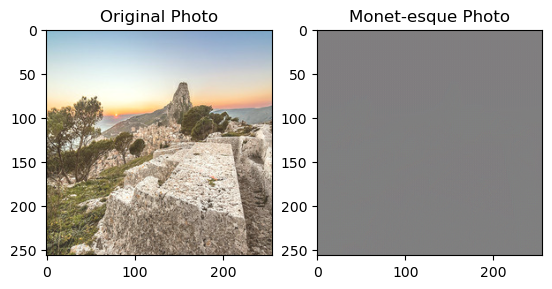

In [ ]:
example_photo = next(iter(photo_ds))
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Build the CycleGAN Model

We subclass `tf.keras.Model` to wrap the full CycleGAN.  
In each training step:  
- A **photo → Monet → photo** and a **Monet → photo → Monet** cycle are performed.  
- **Cycle-consistency loss** encourages the image to remain the same after a round trip.  
- Two generators try to fool two discriminators, while the discriminators learn to tell real from fake.  


In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Define loss functions


CycleGAN training combines several losses, each serving a different role:

- **Discriminator loss**: teaches discriminators to output 1 for real images and 0 for generated images.  
- **Generator loss**: encourages generators to fool discriminators into predicting their outputs as real.  
- **Cycle-consistency loss**: ensures that if an image is translated to the other domain and back, it remains close to the original.  
- **Identity loss**: encourages generators not to change images that already belong to their target domain (e.g., photo → photo).  

Together, these losses balance realism, content preservation, and style transformation.


In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train Model

In [ ]:
class EpochAverageLogs(tf.keras.callbacks.Callback):
    """
    Averages selected log keys over training batches so CSVLogger records clean scalars.
    """
    def __init__(self, keys):
        super().__init__()
        self.keys = tuple(keys)
        self._reset()

    def _reset(self):
        self.sums = {k: 0.0 for k in self.keys}
        self.count = 0

    def _to_float(self, v):
        if isinstance(v, (list, tuple)):
            return float(np.mean([self._to_float(x) for x in v]))
        if tf.is_tensor(v):
            v = v.numpy()
        if isinstance(v, np.ndarray):
            return float(np.mean(v))
        return float(v)

    def on_train_batch_end(self, batch, logs=None):
        if not logs:
            return
        self.count += 1
        for k in self.keys:
            if k in logs:
                try:
                    self.sums[k] += self._to_float(logs[k])
                except Exception:
                    pass  # ignore weird/unexpected types

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.count > 0:
            for k in self.keys:
                logs[k] = self.sums[k] / self.count
        self._reset()


In [ ]:
def run_training_once(seed: int,
                      out_root: str,
                      epochs: int = 25,
                      monet_files=MONET_FILENAMES,
                      photo_files=PHOTO_FILENAMES):


    # --------------------- Helpers ---------------------
    def set_global_seed(seed_val):
        os.environ["PYTHONHASHSEED"] = str(seed_val)
        random.seed(seed_val)
        np.random.seed(seed_val)
        tf.random.set_seed(seed_val)

    def make_outdir(root, seed_val):
        out = Path(root) / f"seed_{seed_val:04d}"
        (out / "images").mkdir(parents=True, exist_ok=True)

        (out / "ckpts").mkdir(parents=True, exist_ok=True)
        return out

    VALID_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

    def sanitize_fname(raw_name: str, default_ext: str) -> str:
        """Ensure basename only, valid extension, and trimmed/cleaned name."""
        p = Path(raw_name)
        base = p.name  # drop directories if any
        ext = Path(base).suffix.lower()
        if ext not in VALID_EXTS:
            base = Path(base).stem + default_ext
        # light cleanup
        base = base.replace("\n", "_").replace("\r", "_").strip()
        # avoid accidental empties
        if base == "" or base in {".", ".."}:
            base = f"img_{seed}_{np.random.randint(1e9)}{default_ext}"
        return base


    def pick_default_ext(array_like) -> str:
        try:
            if array_like.ndim == 2:
                return ".png"
            if array_like.ndim == 3 and array_like.shape[-1] in (1,):
                return ".png"
            return ".jpg"
        except Exception:
            return ".jpg"

    # ---------------------- Build data ----------------------
    def build_datasets(monet_files, photo_files, batch_size=1, seed_val=0):
        # Monet: as-is (NO preprocessing)
        monet = load_dataset(monet_files)

        # Photo: apply channel-matching preprocessing ONLY to photos
        photo = load_dataset(photo_files)
        photo = photo.map(preprocess_photo_to_monet,
                          num_parallel_calls=tf.data.AUTOTUNE)

        monet = monet.shuffle(2048, seed=seed_val, reshuffle_each_iteration=True).batch(batch_size)
        photo = photo.shuffle(2048, seed=seed_val, reshuffle_each_iteration=True).batch(batch_size)
        return monet, photo

    # ---------------------- Setup ----------------------
    tf.keras.backend.clear_session()
    set_global_seed(seed)
    outdir = make_outdir(out_root, seed)
    print(f"\n=== Training seed {seed} ===\nOutputs -> {outdir}")

    monet_ds, photo_ds = build_datasets(monet_files, photo_files, batch_size=1, seed_val=seed)

    with strategy.scope():
        m_gen = Generator()
        p_gen = Generator()
        m_disc = Discriminator()
        p_disc = Discriminator()

        m_gen_opt  = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        p_gen_opt  = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        m_disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        p_disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        cyclegan = CycleGan(m_gen, p_gen, m_disc, p_disc)
        cyclegan.compile(
            m_gen_optimizer=m_gen_opt, p_gen_optimizer=p_gen_opt,
            m_disc_optimizer=m_disc_opt, p_disc_optimizer=p_disc_opt,
            gen_loss_fn=generator_loss, disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss, identity_loss_fn=identity_loss
        )

    # ---------------------- Train ----------------------
    avg_cb = EpochAverageLogs(keys=[
        "monet_gen_loss", "photo_gen_loss",
        "monet_disc_loss", "photo_disc_loss"
    ])

    csv_logger = tf.keras.callbacks.CSVLogger(str(outdir / "training_log.csv"))
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=str(outdir / "ckpts" / "weights_epoch{epoch:03d}.weights.h5"),
        save_weights_only=True,
        save_best_only=False
    )

    cyclegan.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=epochs,
        callbacks=[avg_cb, csv_logger, ckpt_cb]
    )

    # ---------------- Save sub-model weights ----------------
    dummy = tf.zeros((1, 256, 256, 3))
    _ = m_gen(dummy); _ = p_gen(dummy); _ = m_disc(dummy); _ = p_disc(dummy)

    m_gen.save_weights(str(outdir / "m_gen_weights.weights.h5"))
    p_gen.save_weights(str(outdir / "p_gen_weights.weights.h5"))
    m_disc.save_weights(str(outdir / "m_disc_weights.weights.h5"))
    p_disc.save_weights(str(outdir / "p_disc_weights.weights.h5"))

    ckpt = tf.train.Checkpoint(
        m_gen=m_gen, p_gen=p_gen, m_disc=m_disc, p_disc=p_disc,
        m_gen_opt=m_gen_opt, p_gen_opt=p_gen_opt,
        m_disc_opt=m_disc_opt, p_disc_opt=p_disc_opt
    )
    ckpt_path = ckpt.save(str(outdir / "ckpts" / "ckpt"))
    print("Saved checkpoint:", ckpt_path)

    # ------------------ Export predictions ------------------
    # Unshuffled stream that yields (image, image_name)
    export_ds = load_dataset(photo_files, with_name=True)
    export_ds = export_ds.map(
        lambda img, name: (preprocess_photo_to_monet(img), name),
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(1).prefetch(tf.data.AUTOTUNE)

    gen_dir = outdir / "generated_full"
    gen_dir.mkdir(exist_ok=True)

    for img, name in export_ds:
        # Predict in [-1, 1]
        pred = m_gen(img, training=False)[0].numpy()
        # Convert to uint8 [0, 255]
        pred_u8 = ((pred * 127.5) + 127.5).clip(0, 255).astype(np.uint8)

        # Get original filename and make it safe + with extension
        raw_name = name.numpy()[0].decode("utf-8")
        default_ext = pick_default_ext(pred_u8)
        safe_name = sanitize_fname(raw_name, default_ext)
        save_path = gen_dir / safe_name

        # Build PIL image and ensure mode is valid for the chosen format
        img_pil = Image.fromarray(pred_u8 if pred_u8.ndim == 2 or pred_u8.shape[-1] != 1
                                  else pred_u8.squeeze(-1))

        ext = save_path.suffix.lower()
        if ext in {".jpg", ".jpeg"} and img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        fmt = "JPEG" if ext in {".jpg", ".jpeg"} else "PNG" if ext == ".png" else None
        img_pil.save(save_path, format=fmt)

    return outdir

In [ ]:
OUTPUT_ROOT = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments"
SEEDS = [42, 17, 29]
EPOCHS = 50

run_dirs = []
for s in SEEDS:
    run_dirs.append(run_training_once(seed=s, out_root=OUTPUT_ROOT, epochs=EPOCHS))



=== Training seed 42 ===
Outputs -> /sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments/seed_0042
Epoch 1/50
300/300 [==============================] - 45s 64ms/step - monet_gen_loss: 4.8847 - photo_gen_loss: 4.8381 - monet_disc_loss: 0.6306 - photo_disc_loss: 0.6190
Epoch 2/50
300/300 [==============================] - 20s 64ms/step - monet_gen_loss: 3.4537 - photo_gen_loss: 3.3360 - monet_disc_loss: 0.6231 - photo_disc_loss: 0.6824
Epoch 3/50
300/300 [==============================] - 20s 64ms/step - monet_gen_loss: 3.4708 - photo_gen_loss: 3.2175 - monet_disc_loss: 0.6177 - photo_disc_loss: 0.6831
Epoch 4/50
300/300 [==============================] - 20s 64ms/step - monet_gen_loss: 3.2095 - photo_gen_loss: 3.0887 - monet_disc_loss: 0.6723 - photo_disc_loss: 0.6793
Epoch 5/50
300/300 [==============================] - 20s 64ms/step - monet_gen_loss: 2.9540 - photo_gen_loss: 2.8840 - monet_disc_loss: 0.67

## Test

In [ ]:
OUTPUT_ROOT = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments"

# Collect all seed_xxxx folders inside OUTPUT_ROOT
run_dirs = sorted(Path(OUTPUT_ROOT).glob("seed_*"))
print(run_dirs)  # confirm we got them

[PosixPath('/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments/seed_0017'), PosixPath('/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments/seed_0029'), PosixPath('/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments/seed_0042')]


We plot the Monet generator loss across epochs for each training run (different random seeds) to check consistency and stability.  

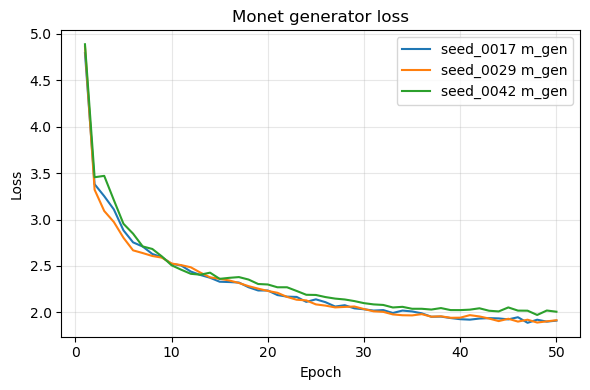

In [ ]:
plt.figure(figsize=(6, 4))

for rd in run_dirs:
    csv_path = Path(rd) / "training_log.csv"
    epochs, losses = [], []

    with open(csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            epochs.append(int(row["epoch"]) + 1)
            losses.append(float(row["monet_gen_loss"]))

    plt.plot(epochs, losses, label=f"{Path(rd).name} m_gen")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Monet generator loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

Now, we evaluate model performance using **MiFID** (memorization-informed FID), the official competition metric for measuring similarity between generated Monet images and real Monet paintings.  

In [ ]:
# Paths
OUTPUT_ROOT = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments"
DATA_ROOT   = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/gan-getting-started"
REAL_MONET_DIR = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/monet_jpgs_for_eval"

# Export Monet JPGs from TFRecords if needed
MONET_FILENAMES = tf.io.gfile.glob(str(Path(DATA_ROOT) / "monet_tfrec" / "*.tfrec"))
mf.ensure_monet_jpgs_from_tfrec(MONET_FILENAMES, REAL_MONET_DIR)

# Evaluate MiFID per run
run_dirs = sorted(p for p in Path(OUTPUT_ROOT).glob("seed_*") if p.is_dir())
rows = []
for rd in run_dirs:
    gen_dir = rd / "generated_full"
    res = mf.compute_mifid(REAL_MONET_DIR, gen_dir, epsilon=0.10, batch=64)
    rows.append({"run": rd.name, **res})

# Sort by MiFID
rows.sort(key=lambda r: r["MiFID"])

# Per-run table
print("\nMiFID results (sorted by MiFID):")
print(f"{'run':<12} {'FID':>10} {'d':>10} {'d_thr':>10} {'MiFID':>12}")
for r in rows:
    print(f"{r['run']:<12} {r['FID']:>10.4f} {r['d']:>10.4f} {r['d_thr']:>10.4f} {r['MiFID']:>12.4f}")

# Summary across runs (mean & std)
def mean_std(vals):
    arr = np.asarray(vals, dtype=float)
    n = arr.size
    mean = float(arr.mean()) if n else float("nan")
    std  = float(arr.std(ddof=1)) if n > 1 else 0.0
    return mean, std

metrics = ["FID", "MiFID"]
print("\nSummary across runs:")
print(f"{'metric':<8} {'mean':>12} {'std':>12}")
for m in metrics:
    mean, std = mean_std([r[m] for r in rows])
    print(f"{m:<8} {mean:>12.4f} {std:>12.4f}")

[mifid] Exported 300 Monet images to /sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/monet_jpgs_for_eval

MiFID results (sorted by MiFID):
run                 FID          d      d_thr        MiFID
seed_0042       89.2493     0.2494     1.0000      89.2493
seed_0017       93.8975     0.2548     1.0000      93.8975
seed_0029       95.6276     0.2561     1.0000      95.6276

Summary across runs:
metric           mean          std
FID           92.9248       3.2985
MiFID         92.9248       3.2985


Finally, we showcase **qualitative results** by displaying four translations (two successful and two less convincing) from photos to Monet-style images.

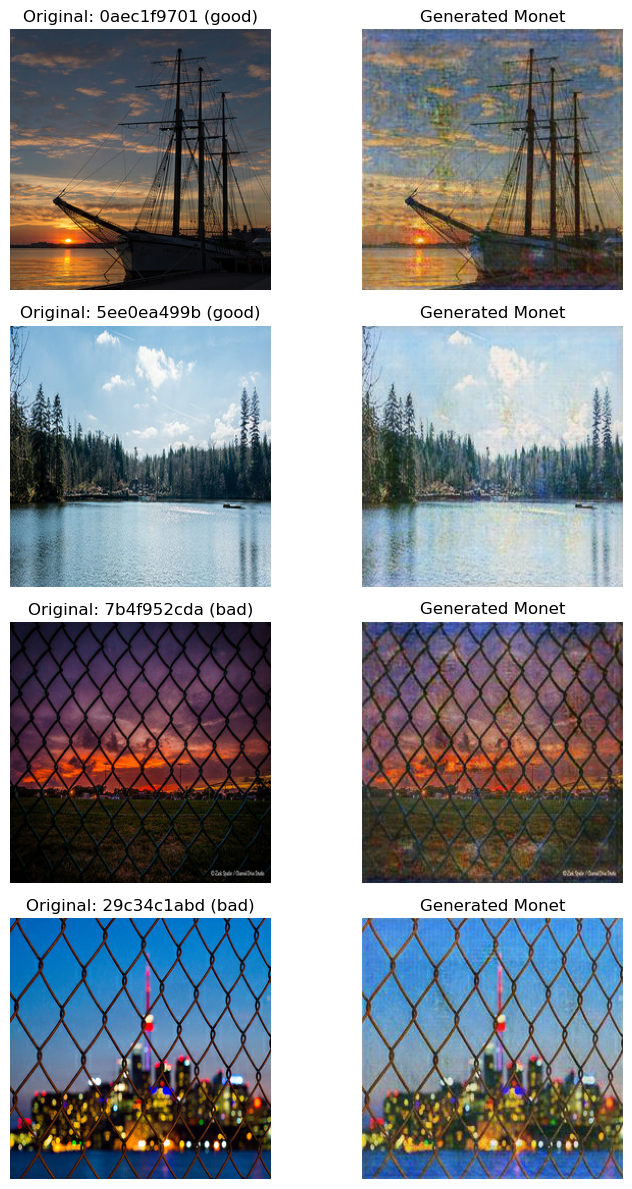

In [ ]:
# ---- paths ----
RUN_DIR = Path(OUTPUT_ROOT) / "seed_0042"
GEN_DIR = RUN_DIR / "generated_full"
REAL_MONET_DIR = Path("/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/monet_jpgs_for_eval")

# ---- compute Inception features using MiFID helpers ----
real_paths = mf._list_images(REAL_MONET_DIR)
gen_paths  = mf._list_images(GEN_DIR)
assert len(real_paths) > 0 and len(gen_paths) > 0, "Empty real/gen image folders."

inc = mf.InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))
f_real = mf._get_inception_features(real_paths, inc, batch=64)
f_gen  = mf._get_inception_features(gen_paths,  inc, batch=64)

# distance per generated
D = mf._cosine_distance_matrix(f_gen, f_real)   # [Ngen, Nreal]
d_per_gen = D.min(axis=1)

# ---- pick 2 best (smallest d) and 2 worst (largest d) ----
idx_sorted = np.argsort(d_per_gen)
good_idx = idx_sorted[:2]
bad_idx  = idx_sorted[-2:]
sel_idx = list(good_idx) + list(bad_idx)

sel_gen_paths = [gen_paths[i] for i in sel_idx]
sel_names = [Path(p).name for p in sel_gen_paths]
labels = ["good", "good", "bad", "bad"]

# ---- fetch matching ORIGINAL photos ----
def norm_all_keys(name_str: str):
    bname = Path(name_str).name
    stem = Path(bname).stem
    return {bname.casefold(), stem.casefold()}

orig_map = {}
name_index = {}

photo_named_ds = load_dataset(PHOTO_FILENAMES, with_name=True).batch(1)
for img, name in photo_named_ds:
    nm = name.numpy()[0].decode("utf-8", errors="ignore")
    arr = img.numpy()[0]                                   # [-1,1]
    arr_u8 = ((arr * 127.5) + 127.5).clip(0, 255).astype(np.uint8)

    for k in norm_all_keys(nm):
        if k not in orig_map:
            orig_map[k] = arr_u8
    name_index[Path(nm).stem.casefold()] = Path(nm).name

resolved_pairs = []
missing = []

for gen_p in sel_gen_paths:
    gen_name = Path(gen_p).name
    found = None
    for k in norm_all_keys(gen_name):
        if k in orig_map:
            found = k
            break
    if found is None:
        missing.append(gen_name)
    else:
        orig_img = orig_map[found]
        gen_img = np.array(Image.open(gen_p))
        pretty = name_index.get(Path(gen_name).stem.casefold(), gen_name)
        resolved_pairs.append((pretty, orig_img, gen_img))

assert not missing, f"Could not find originals for: {missing}"

# ---- show side-by-side ----
fig, axes = plt.subplots(len(resolved_pairs), 2, figsize=(8, 3*len(resolved_pairs)))
if len(resolved_pairs) == 1:
    axes = np.array([axes])

for row, (disp_name, orig_img, gen_img) in enumerate(resolved_pairs):
    tag = labels[row]

    axes[row, 0].imshow(orig_img)
    axes[row, 0].set_title(f"Original: {disp_name} ({tag})")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(gen_img)
    axes[row, 1].set_title("Generated Monet")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()